In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [93]:
batch_size = 10
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)


In [94]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
labels.shape

torch.Size([10])

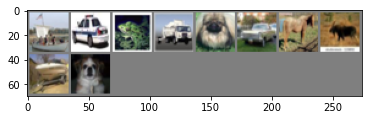

 ship   car  frog truck   dog   car horse  deer  ship   dog


In [95]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [96]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1=nn.BatchNorm2d(32)
        self.bn2=nn.BatchNorm2d(64)
        self.bn3=nn.BatchNorm2d(128)

        self.conv1 = nn.Conv2d(3, 32, 3,padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3,padding=1)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 206)
        self.fc3 = nn.Linear(206, 103)
        self.fc4 = nn.Linear(103, 10)
        
        
        self.dropout = nn.Dropout(p=.25)


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x=self.fc4(x)
        return F.log_softmax(x, dim=1)

net = Net()

In [97]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [98]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 1.866
[1,  2000] loss: 1.583
[1,  3000] loss: 1.466
[1,  4000] loss: 1.378
[1,  5000] loss: 1.295
[2,  1000] loss: 1.213
[2,  2000] loss: 1.168
[2,  3000] loss: 1.147
[2,  4000] loss: 1.097
[2,  5000] loss: 1.092
[3,  1000] loss: 1.007
[3,  2000] loss: 1.009
[3,  3000] loss: 0.964
[3,  4000] loss: 0.955
[3,  5000] loss: 0.962
[4,  1000] loss: 0.891
[4,  2000] loss: 0.859
[4,  3000] loss: 0.865
[4,  4000] loss: 0.890
[4,  5000] loss: 0.846
[5,  1000] loss: 0.795
[5,  2000] loss: 0.797
[5,  3000] loss: 0.797
[5,  4000] loss: 0.789
[5,  5000] loss: 0.785
[6,  1000] loss: 0.707
[6,  2000] loss: 0.744
[6,  3000] loss: 0.733
[6,  4000] loss: 0.730
[6,  5000] loss: 0.734
[7,  1000] loss: 0.639
[7,  2000] loss: 0.676
[7,  3000] loss: 0.684
[7,  4000] loss: 0.678
[7,  5000] loss: 0.681
[8,  1000] loss: 0.612
[8,  2000] loss: 0.609
[8,  3000] loss: 0.614
[8,  4000] loss: 0.651
[8,  5000] loss: 0.646
[9,  1000] loss: 0.552
[9,  2000] loss: 0.583
[9,  3000] loss: 0.583
[9,  4000] 

In [99]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

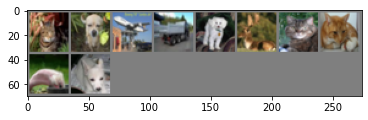

GroundTruth:    cat   dog plane truck   dog  deer   cat   cat  bird   dog


In [100]:
dataiter = iter(testloader)

images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [101]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [102]:
outputs = net(images)

In [104]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

Predicted:   frog   dog  deer truck   dog  deer   cat   cat   cat   dog


In [105]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 75 %


In [106]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 81.0 %
Accuracy for class car   is: 86.1 %
Accuracy for class bird  is: 65.3 %
Accuracy for class cat   is: 57.1 %
Accuracy for class deer  is: 65.6 %
Accuracy for class dog   is: 68.4 %
Accuracy for class frog  is: 79.0 %
Accuracy for class horse is: 77.4 %
Accuracy for class ship  is: 86.0 %
Accuracy for class truck is: 84.6 %
